In [1]:
is_skip = False

# Data params
desired_batch_size = 128
# batch_size = 32
batch_size = 16
grad_accm_step_max = desired_batch_size // batch_size
print(grad_accm_step_max)

# Model params
d_model = 128
nhead = 2
d_ff = 256
dropout = 0.1
encoder_num_layers = 2
feature_encoder_num_layers = 2
decoder_num_layers = 2
num_layers = [encoder_num_layers, feature_encoder_num_layers, decoder_num_layers]

patch_size = 10

8


# Import

In [2]:
import os
import joblib
import copy
import time
import math

from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

from PIL import Image
from torchvision import transforms
import cv2
from transformers import ViTImageProcessor, MobileViTModel, MobileViTConfig, ViTModel, AutoImageProcessor, ViTConfig, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer, Dinov2Config, Dinov2Model
from skimage import io

device = torch.device("cuda")
# device = torch.device("cpu")
tqdm.pandas()

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### Read

In [3]:
if not is_skip:
    us_holiday = holidays.US()
    
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})

    min_year = df_trans["t_dat"].dt.year.min()
    max_year = df_trans["t_dat"].dt.year.max()

    holiday = holidays.US(years=(min_year, max_year))
    holiday = pd.DataFrame({"t_dat":holiday.keys(), "holiday":holiday.values()})
    holiday["t_dat"] = pd.to_datetime(holiday["t_dat"])

In [ ]:
def preprocess(data):
    data = data.copy()

    # Image path
    data["img_path"] = data["article_id"].apply(lambda x: f'../HnM/resized_images/{x[:3]}/{x}.jpg')
    data["is_valid"] = data["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    data = data[data["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image

    # Make sales
    data = data.groupby(["t_dat", "article_id", "img_path"], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[(data["size"]>=300)]

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")
    data["img_path"] = data["img_path"].fillna(method="ffill")
    data = data.sort_values(["article_id", "t_dat"])
    
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    # data = data[(data["size"]>=365)]
    data["time_idx"] = data.groupby("article_id").cumcount()
    data["time_idx"] = data["size"] - data["time_idx"]

    # Make holidays
    data = pd.merge(data, holiday, on="t_dat", how="left")
    display(data)

    # Temporal information
    # Make sure the sequence start from 0
    data["day"] = data["t_dat"].dt.day - 1
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month - 1
    data["year"] = data["t_dat"].dt.year / (data["t_dat"].dt.year.max() + 1)

    # Append meta data
    # data = data.merge(df_meta[["index_name", "article_id", "colour_group_name", "graphical_appearance_name", "product_type_name"]], on="article_id")
    data = data.merge(df_meta[["index_name", "article_id", "colour_group_name", "graphical_appearance_name", "prod_name"]], on="article_id")
    data = data.rename(columns={"prod_name":"product_type_name"})

    # Output
    return data.reset_index(drop=True)

if not is_skip:
    df_prep = df_trans.copy()#.iloc[:1000]
    data = preprocess(df_prep)
    
    data.to_parquet("data.pq")

,level_0,t_dat,article_id,img_path,sales,price,size,time_idx,holiday
0,0,2018-09-20,0108775015,../HnM/resized_images/010/0108775015.jpg,30.0,0.008445,672,672,NaN
1,0,2018-09-21,0108775015,../HnM/resized_images/010/0108775015.jpg,48.0,0.008194,672,671,NaN
2,0,2018-09-22,0108775015,../HnM/resized_images/010/0108775015.jpg,11.0,0.008458,672,670,NaN
3,0,2018-09-23,0108775015,../HnM/resized_images/010/0108775015.jpg,26.0,0.008425,672,669,NaN
4,0,2018-09-24,0108775015,../HnM/resized_images/010/0108775015.jpg,33.0,0.008406,672,668,NaN
...,...,...,...,...,...,...,...,...,...
1665369,2703,2020-09-18,0832616001,../HnM/resized_images/083/0832616001.jpg,0.0,0.030492,408,5,NaN
1665370,2703,2020-09-19,0832616001,../HnM/resized_images/083/0832616001.jpg,0.0,0.030492,408,4,NaN
1665371,2703,2020-09-20,0832616001,../HnM/resized_images/083/0832616001.jpg,1.0,0.030492,408,3,NaN
1665372,2703,2020-09-21,0832616001,../HnM/resized_images/083/0832616001.jpg,0.0,0.030492,408,2,NaN


### Dataset

In [ ]:
class LogScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return np.log1p(x)
    
    def inverse_transform(self, x, y=None):
        return np.expm1(x)
    
class NoneScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        x = x.copy()
        return x
    
    def inverse_transform(self, x, y=None):
        x = x.copy()
        return x

In [ ]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapper = {}
        self.idx = 0

    def fit(self, x, y=None):
        x = set(x)
        for val in x:
            if val not in self.mapper.keys():
                self.mapper[val] = self.idx
                self.idx += 1
        return self
    
    def transform(self, x, y=None):
        res = []
        for val in x:
            if val in self.mapper.keys():
                res.append(self.mapper[val])
            else:
                res.append(self.idx)
        return np.array(res)

In [ ]:
data = pd.read_parquet("data.pq")
df_train = data[data["time_idx"]<=365]
df_valid = data[data["time_idx"]<=365+90]

# df_train = df_train[df_train["index_name"] == "Ladieswear"]
# df_valid = df_valid[df_valid["index_name"] == "Ladieswear"]

remain_mask_val = 0
hide_mask_val = 1
padding_mask_val = 2

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, is_train=True, encoder_dict=None):
        # Define parameters
        self.is_train = is_train
        # self.transform = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        if is_train:
            self.holiday_encoder = CustomLabelEncoder()
            self.index_encoder = CustomLabelEncoder()
            self.color_encoder = CustomLabelEncoder()
            self.graphic_encoder = CustomLabelEncoder()
            self.product_encoder = CustomLabelEncoder()

            self.holiday_encoder.fit(data["holiday"])
            self.index_encoder.fit(data["index_name"])
            self.color_encoder.fit(data["colour_group_name"])
            self.graphic_encoder.fit(data["graphical_appearance_name"])
            self.product_encoder.fit(data["product_type_name"])
        else: 
            self.holiday_encoder = encoder_dict["holiday_encoder"]
            self.index_encoder = encoder_dict["index_encoder"]
            self.color_encoder = encoder_dict["color_encoder"]
            self.graphic_encoder = encoder_dict["graphic_encoder"]
            self.product_encoder = encoder_dict["product_encoder"]
            
        # Iterate each product
        self.data_li = []
        self.min_val, self.max_val = data["sales"].min(), data["sales"].max()
        data.groupby("article_id").progress_apply(lambda x: self.data_li.append(x))
    
    def get_encoder_dict(self):
        return {"holiday_encoder": self.holiday_encoder,
                "index_encoder": self.index_encoder,
                "color_encoder": self.color_encoder,
                "graphic_encoder": self.graphic_encoder,
                "product_encoder": self.product_encoder}

    def __len__(self):
        return len(self.data_li)
    
    def __getitem__(self, idx):
        # Obtain information about data for each
        data = self.data_li[idx]
        
        # Label encode
        data["holiday"] = self.holiday_encoder.transform(data["holiday"])
        data["index_name"] = self.index_encoder.transform(data["index_name"])
        data["colour_group_name"] = self.color_encoder.transform(data["colour_group_name"])
        data["graphical_appearance_name"] = self.graphic_encoder.transform(data["graphical_appearance_name"])
        data["product_type_name"] = self.product_encoder.transform(data["product_type_name"])

        # Name each and scale data
        sales_scaler, price_scaler = StandardScaler(), MinMaxScaler() # ----------------------------------------------------------------------------------
        ## Sales information
        sales = sales_scaler.fit_transform(data["sales"].values.reshape(-1,1)).reshape(-1)
        y = sales_scaler.transform(data["sales"].values.reshape(-1,1)).reshape(-1)
        ## Temporal information
        dow = data["dow"].values
        month = data["month"].values
        holiday = data["holiday"].values
        price = price_scaler.fit_transform(data["price"].values.reshape(-1,1)).reshape(-1)
        ## Static information
        index_name = data["index_name"].values[[0]]
        colour_group_name = data["colour_group_name"].values[[0]]
        graphical_appearance_name = data["graphical_appearance_name"].values[[0]]
        product_type_name = data["product_type_name"].values[[0]]
        img_path = data["img_path"].values[0]
        img_raw = Image.open(img_path).convert("RGB")
        img_input = self.transform(img_raw).squeeze()

        # Generate mask
        if self.is_train:
            # When training, mask random time steps
            data, mask = self.generate_mask(sales, sales_scaler)
        else:
            data, mask = self.generate_valid_mask(sales)
        
        return {"sales": torch.Tensor(sales), 
                "dow":torch.IntTensor(dow), "month":torch.IntTensor(month), "holiday":torch.IntTensor(holiday), "price":torch.Tensor(price),
                "index_name": torch.IntTensor(index_name), "colour_group_name": torch.IntTensor(colour_group_name), "graphical_appearance_name": torch.IntTensor(graphical_appearance_name), "product_type_name": torch.IntTensor(product_type_name), 
                "img_raw":img_raw, "img_input": img_input,
                "length": len(y), "mask": torch.IntTensor(mask),
                "y":torch.Tensor(y)}

    def generate_mask(self, data, scaler):
        index = np.arange(len(data)) # Index for each time step
        num_masks = int(len(data) * 0.8) # Amont of masked values ------------------------------------------------------------------------------------------------------------
        candidate_idx = np.random.choice(index, num_masks, replace=False) # Indexes to be masked
        assert num_masks == len(candidate_idx), "Not enough masks"
        
        mask = [remain_mask_val]
        for i in index:
            if i in candidate_idx:
                data[i] = 0
                mask.append(hide_mask_val)
            else:
                mask.append(remain_mask_val)
        
        assert len(mask) == len(data)+1
        return data, mask

    def generate_valid_mask(self, data):
        data[-90:] = 0

        mask = np.zeros(len(data)+1) + remain_mask_val
        mask[-90:] = hide_mask_val

        assert len(mask) == len(data)+1

        return data, mask

def collate_fn(batch_li):
    # Get data
    sales = [batch["sales"] for batch in batch_li]
    dow = [batch["dow"] for batch in batch_li]
    month = [batch["month"] for batch in batch_li]
    holiday = [batch["holiday"] for batch in batch_li]
    index_name = [batch["index_name"] for batch in batch_li]
    colour_group_name = [batch["colour_group_name"] for batch in batch_li]
    graphical_appearance_name = [batch["graphical_appearance_name"] for batch in batch_li]
    product_type_name = [batch["product_type_name"] for batch in batch_li]
    price = [batch["price"] for batch in batch_li]
    length = [batch["length"] for batch in batch_li]
    mask = [batch["mask"] for batch in batch_li]
    
    img_raw = [batch["img_raw"] for batch in batch_li]
    img_input = torch.stack([batch["img_input"] for batch in batch_li])

    y = [batch["y"] for batch in batch_li]

    # Pad data
    # We determine whether each position is valid or mask or padding with only `mask`.
    # Therefore, padding value for others are irrelavent but matters only for `mask`
    sales = torch.nn.utils.rnn.pad_sequence(sales, batch_first=True)
    dow = torch.nn.utils.rnn.pad_sequence(dow, batch_first=True)
    month = torch.nn.utils.rnn.pad_sequence(month, batch_first=True)
    holiday = torch.nn.utils.rnn.pad_sequence(holiday, batch_first=True)
    price = torch.nn.utils.rnn.pad_sequence(price, batch_first=True)
    mask = torch.nn.utils.rnn.pad_sequence(mask, batch_first=True, padding_value=padding_mask_val)
    y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True)
    
    return {"sales": sales, 
            "dow":dow, "month":month, "holiday":holiday, "price":price, 
            "index_name": torch.stack(index_name), "colour_group_name": torch.stack(colour_group_name), "graphical_appearance_name": torch.stack(graphical_appearance_name), "product_type_name": torch.stack(product_type_name),
            "length": torch.IntTensor(length), "mask":mask,
            "img_raw": img_raw, "img_input":img_input,
            "y":y}

train_dataset = Dataset(df_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

valid_dataset = Dataset(df_valid, is_train=False, encoder_dict=train_dataset.get_encoder_dict())
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

for data in train_dataloader:
    print("sales:", data["sales"].shape)
    print("price:", data["price"].shape)
    print("dow:", data["dow"].shape)
    print("index_name:", data["index_name"].shape)
    print("img_input", data["img_input"].shape)
    print("y:", data["y"].shape)
    print("length:", data["length"].shape)
    break

100%|██████████| 2704/2704 [00:00<00:00, 35044.55it/s]


sales: torch.Size([16, 365])
price: torch.Size([16, 365])
dow: torch.Size([16, 365])
index_name: torch.Size([16, 1])
img_input torch.Size([16, 3, 224, 224])
y: torch.Size([16, 365])
length: torch.Size([16])


In [ ]:
for valid_data in valid_dataloader:
    print("sales:", valid_data["sales"].shape)
    print("price:", valid_data["price"].shape)
    print("mask:", valid_data["mask"].shape)
    print("y:", valid_data["y"].shape)
    print("length:", valid_data["length"].shape)
    break

sales: torch.Size([16, 455])
price: torch.Size([16, 455])
mask: torch.Size([16, 456])
y: torch.Size([16, 455])
length: torch.Size([16])


# Architecture

### Helper

In [ ]:
from torch.nn import functional as F
def _generate_square_subsequent_mask(sz, device, dtype):
    return torch.triu(
        torch.full((sz, sz), float('-inf'), dtype=dtype, device=device),
        diagonal=1,
    )

def _get_seq_len(src, batch_first):
    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

def _detect_is_causal_mask(mask, is_causal=None,size=None):
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal

class EncoderLayer(torch.nn.TransformerEncoderLayer):
    def forward(self, src, pos_enc, src_mask=None, src_key_padding_mask=None, is_causal=False):
        x = src
        attn_output, attn_weight = self._sa_block(x, pos_enc, src_mask, src_key_padding_mask, is_causal=is_causal)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self._ff_block(x))

        return x, attn_weight

    # self-attention block
    def _sa_block(self, x, pos_enc, attn_mask, key_padding_mask, is_causal=False):
        x, attn_weight = self.self_attn(x+pos_enc, x+pos_enc, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=True, is_causal=is_causal, average_attn_weights=False)
        return self.dropout1(x), attn_weight

class Encoder(torch.nn.TransformerEncoder):
    def forward(self, src, pos_enc=0, mask=None, src_key_padding_mask=None, is_causal=None):
       ################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(mask),
            other_name="mask",
            target_type=src.dtype
        )

        mask = F._canonical_mask(
            mask=mask,
            mask_name="mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        src_key_padding_mask_for_layers = src_key_padding_mask
        why_not_sparsity_fast_path = ''
        str_first_layer = "self.layers[0]"
        batch_first = first_layer.self_attn.batch_first
        if not hasattr(self, "use_nested_tensor"):
            why_not_sparsity_fast_path = "use_nested_tensor attribute not present"
        elif not self.use_nested_tensor:
            why_not_sparsity_fast_path = "self.use_nested_tensor (set in init) was not True"
        elif first_layer.training:
            why_not_sparsity_fast_path = f"{str_first_layer} was in training mode"
        elif not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif src_key_padding_mask is None:
            why_not_sparsity_fast_path = "src_key_padding_mask was None"
        elif (((not hasattr(self, "mask_check")) or self.mask_check)
                and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):
            why_not_sparsity_fast_path = "mask_check enabled, and src and src_key_padding_mask was not left aligned"
        elif output.is_nested:
            why_not_sparsity_fast_path = "NestedTensor input is not supported"
        elif mask is not None:
            why_not_sparsity_fast_path = "src_key_padding_mask and mask were both supplied"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"

        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                first_layer.self_attn.in_proj_weight,
                first_layer.self_attn.in_proj_bias,
                first_layer.self_attn.out_proj.weight,
                first_layer.self_attn.out_proj.bias,
                first_layer.norm1.weight,
                first_layer.norm1.bias,
                first_layer.norm2.weight,
                first_layer.norm2.bias,
                first_layer.linear1.weight,
                first_layer.linear1.bias,
                first_layer.linear2.weight,
                first_layer.linear2.bias,
            )
            _supported_device_type = ["cpu", "cuda", torch.utils.backend_registration._privateuse1_backend_name]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif src.device.type not in _supported_device_type:
                why_not_sparsity_fast_path = f"src device is neither one of {_supported_device_type}"
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if (not why_not_sparsity_fast_path) and (src_key_padding_mask is not None):
                convert_to_nested = True
                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
                src_key_padding_mask_for_layers = None

        seq_len = _get_seq_len(src, batch_first)
        is_causal = _detect_is_causal_mask(mask, is_causal, seq_len)
       ################################################################################################################

        for mod in self.layers:
            output, attn_weight = mod(output, pos_enc, src_mask=mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask_for_layers)

        if convert_to_nested:
            output = output.to_padded_tensor(0., src.size())

        if self.norm is not None:
            output = self.norm(output)

        return output, attn_weight

In [ ]:
def get_positional_encoding(seq_len=1000):
    position = torch.arange(seq_len).reshape(-1,1).to(device)
    i = torch.arange(d_model).to(device)//2
    exp_term = 2*i/d_model
    div_term = torch.pow(10000, exp_term).reshape(1, -1)
    pos_encoded = position / div_term

    pos_encoded[:, 0::2] = torch.sin(pos_encoded[:, 0::2])
    pos_encoded[:, 1::2] = torch.cos(pos_encoded[:, 1::2])

    return pos_encoded

class FeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, activation):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_model, d_ff)
        self.linear2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout()

        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()

    def forward(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout(x)
    
class SalesEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.embedding = torch.nn.Linear(1, d_model)
        self.global_token = torch.nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_enc = torch.nn.Parameter(get_positional_encoding())

        self.init_weight()
    
    def init_weight(self):
        trunc_normal_(self.global_token, std=1e-6)
        trunc_normal_(self.pos_enc, std=0.02)
    
    def forward(self, sales):
        pos_enc = self.pos_enc[:sales.shape[1]+1, :].repeat(sales.shape[0], 1, 1)
        global_token = self.global_token.repeat(sales.shape[0], 1, 1) # Expand as on batch size dimension
        
        sales_embedding = self.embedding(sales.unsqueeze(-1))
        sales_embedding = torch.cat([global_token, sales_embedding], dim=1)

        return sales_embedding + pos_enc

class TemporalEmbedding(torch.nn.Module):
    def __init__(self, d_model, activation):
        super().__init__()
        num_dow = 7
        num_month = 12
        num_holiday = train_dataset.holiday_encoder.idx + 1 # 1 for unseen label

        # Embedding
        self.dow_embedding = torch.nn.Embedding(num_dow, d_model)
        self.month_embedding = torch.nn.Embedding(num_month, d_model)
        self.holiday_embedding = torch.nn.Embedding(num_holiday, d_model)
        self.price_embedding = torch.nn.Linear(1, d_model)

        # Global token
        self.dow_token = torch.nn.Parameter(torch.zeros(1, 1, d_model))
        self.month_token = torch.nn.Parameter(torch.zeros(1, 1, d_model))
        self.holiday_token = torch.nn.Parameter(torch.zeros(1, 1, d_model))
        self.price_token = torch.nn.Parameter(torch.zeros(1, 1, d_model))

        # Positional encoding
        self.dow_pos_enc = torch.nn.Parameter(get_positional_encoding())
        self.month_pos_enc = torch.nn.Parameter(get_positional_encoding())
        self.holiday_pos_enc = torch.nn.Parameter(get_positional_encoding())
        self.price_pos_enc = torch.nn.Parameter(get_positional_encoding())

        # Encoding
        self.dow_encoding = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout, activation, batch_first=True), encoder_num_layers)
        self.month_encoding = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout, activation, batch_first=True), encoder_num_layers)
        self.holiday_encoding = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout, activation, batch_first=True), encoder_num_layers)
        self.price_encoding = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout, activation, batch_first=True), encoder_num_layers)

        self.init_weight()
    
    def init_weight(self):
        trunc_normal_(self.dow_token, std=1e-6)
        trunc_normal_(self.month_token, std=1e-6)
        trunc_normal_(self.holiday_token, std=1e-6)
        trunc_normal_(self.price_token, std=1e-6)

        trunc_normal_(self.dow_pos_enc, std=0.02)
        trunc_normal_(self.month_pos_enc, std=0.02)
        trunc_normal_(self.holiday_pos_enc, std=0.02)
        trunc_normal_(self.price_pos_enc, std=0.02)
    
    def forward(self, dow, month, holiday, price, mask):
        dow_pos_enc = self.dow_pos_enc[:dow.shape[1]+1, :].repeat(dow.shape[0], 1, 1)
        month_pos_enc = self.month_pos_enc[:dow.shape[1]+1, :].repeat(dow.shape[0], 1, 1)
        holiday_pos_enc = self.holiday_pos_enc[:dow.shape[1]+1, :].repeat(dow.shape[0], 1, 1)
        price_pos_enc = self.price_pos_enc[:dow.shape[1]+1, :].repeat(dow.shape[0], 1, 1)

        dow_token = self.dow_token.repeat(dow.shape[0], 1, 1)
        month_token = self.month_token.repeat(dow.shape[0], 1, 1)
        holiday_token = self.holiday_token.repeat(dow.shape[0], 1, 1)
        price_token = self.price_token.repeat(dow.shape[0], 1, 1)

        # Embedding
        dow_embedding = torch.cat([dow_token, self.dow_embedding(dow)], dim=1) + dow_pos_enc
        month_embedding = torch.cat([month_token, self.month_embedding(month)], dim=1) + month_pos_enc
        holiday_embedding = torch.cat([holiday_token, self.holiday_embedding(holiday)], dim=1) + holiday_pos_enc
        price_embedding = torch.cat([price_token, self.price_embedding(price.unsqueeze(-1))], dim=1) + price_pos_enc

        # Encoding
        dow_encoding, dow_selfattn_weight = self.dow_encoding(dow_embedding, src_key_padding_mask=mask)
        month_encoding, month_selfattn_weight = self.month_encoding(month_embedding, src_key_padding_mask=mask)
        holiday_encoding, holiday_selfattn_weight = self.holiday_encoding(holiday_embedding, src_key_padding_mask=mask)
        price_encoding, price_selfattn_weight = self.price_encoding(price_embedding, src_key_padding_mask=mask)

        return dow_encoding, month_encoding, holiday_encoding, price_encoding, dow_selfattn_weight, month_selfattn_weight, holiday_selfattn_weight, price_selfattn_weight

class StaticEmbedding(torch.nn.Module):
    def __init__(self, d_model, patch_size, activation):
        super().__init__()
        num_index = train_dataset.index_encoder.idx + 1 # 1 for unseen label
        num_color = train_dataset.color_encoder.idx + 1
        num_graphic = train_dataset.graphic_encoder.idx + 1
        num_product = train_dataset.product_encoder.idx + 1

        # Embedding
        self.index_embedding = torch.nn.Embedding(num_index, d_model)
        self.color_embedding = torch.nn.Embedding(num_color, d_model)
        self.graphic_embedding = torch.nn.Embedding(num_graphic, d_model)
        self.product_embedding = torch.nn.Embedding(num_product, d_model)

        # Global token
        self.others_token = torch.nn.Parameter(torch.randn(1, d_model))

        # Encoding
        self.others_encoding = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout, activation, batch_first=True), encoder_num_layers)
        self.others_modality_embedding = torch.nn.Embedding(5, d_model)
        
        # config = ViTConfig(hidden_size=d_model, num_hidden_layers=encoder_num_layers, num_attention_heads=nhead, intermediate_size=d_ff, patch_size=patch_size, encoder_stride=patch_size)
        # self.img_encoding = ViTModel(config)
        self.img_encoding = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
        
        # config = Dinov2Config(hidden_size=d_model, num_hidden_layers=encoder_num_layers, num_attention_heads=nhead, intermediate_size=d_ff, patch_size=patch_size, encoder_stride=patch_size)
        # self.img_encoding = Dinov2Model(config)
        # self.img_encoding = Dinov2Model.from_pretrained("facebook/dinov2-base")
        
        self.img_linear = torch.nn.Linear(768, d_model)

        self.init_weight()
    
    def init_weight(self):
        trunc_normal_(self.others_token, std=1e-6)
    
    def forward(self, index, color, graphic, product, img):
        # Embedding
        index_embedding = self.index_embedding(index.squeeze())
        color_embedding = self.color_embedding(color.squeeze())
        graphic_embedding = self.graphic_embedding(graphic.squeeze())
        product_embedding = self.product_embedding(product.squeeze())

        others_token = self.others_token.repeat(index.shape[0], 1)
        others_embedding = torch.stack([others_token, index_embedding, color_embedding, graphic_embedding, product_embedding], dim=-2)
        others_modality = torch.tensor([0,1,2,3,4]).to(torch.int)
        others_modality_embedding = self.others_modality_embedding(others_modality.to(device))
        # others_embedding = others_embedding + others_modality_embedding
        
        others_encoding, others_attnweight = self.others_encoding(others_embedding)
        
        img_encoding, _, img_attnweight = self.img_encoding(img, output_attentions=True).values()
        img_encoding = self.img_linear(img_encoding)
        
        return others_encoding, img_encoding, others_attnweight, img_attnweight

class FullMultiheadBlockAttention(torch.nn.Module):
    def __init__(self, d_model, nhead, dropout):
        super().__init__()
        self.d_model, self.nhead = d_model, nhead
        self.q_linear = torch.nn.Linear(d_model, d_model)
        self.k_linear = torch.nn.Linear(d_model, d_model)
        self.v_linear = torch.nn.Linear(d_model, d_model)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, tgt_temp, mem_temp, tgt_st=None, mem_st=None, block_mask=None):
        # Linear transform
        Qt = self.q_linear(tgt_temp)
        Kt = self.k_linear(mem_temp)
        Vt = self.v_linear(mem_temp)

        Qs = self.q_linear(tgt_st.unsqueeze(1))
        Ks = self.k_linear(mem_st.unsqueeze(1))
        Vs = self.v_linear(mem_st.unsqueeze(1))

        # Split head
        batch_size, seq_len, _, d_model = Qt.shape
        Qt = Qt.view(batch_size, seq_len, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)
        Kt = Kt.view(batch_size, seq_len, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)
        Vt = Vt.view(batch_size, seq_len, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)

        Qs = Qs.view(batch_size, 1, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)
        Ks = Ks.view(batch_size, 1, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)
        Vs = Vs.view(batch_size, 1, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)

        # Scaled dot product attention
        ## Temporal attention
        ### Temp-temp attention
        Qt_Kt = Qt @ Kt.permute(0,1,2,4,3)
        ### Temp-static attention
        Qt_Ks = Qt @ Ks.permute(0,1,2,4,3)
        ### Get attention weight
        temporal_attention = torch.concat([Qt_Kt, Qt_Ks], dim=-1)
        temporal_attention_weight = torch.nn.functional.softmax(temporal_attention/math.sqrt(d_model//nhead), dim=-1)
        ### Split temporal and static
        temp_temp_attnweight = temporal_attention_weight[..., :Qt_Kt.shape[-1]]
        temp_static_attnweight = temporal_attention_weight[..., -Qt_Ks.shape[-1]:]

        ## Static attention
        Qs_ = Qs.reshape(batch_size, nhead, -1, d_model//nhead)
        Kt_ = Kt.reshape(batch_size, nhead, -1, d_model//nhead)
        Ks_ = Ks.reshape(batch_size, nhead, -1, d_model//nhead)
        K = torch.concat([Kt_, Ks_], dim=-2)
        static_attention = Qs_ @ K.permute(0,1,3,2)
        block_mask = block_mask.unsqueeze(1).unsqueeze(1).repeat(1, static_attention.shape[1], static_attention.shape[2], 1)
        static_attention += block_mask
        static_attention_weight = torch.nn.functional.softmax(static_attention/math.sqrt(d_model//nhead), dim=-1)

        # Attention output
        ## Temporal attention output
        temp_temp_attnoutput = temp_temp_attnweight @ Vt
        temp_static_attnoutput = temp_static_attnweight @ Vs
        temporal_attention_output = temp_temp_attnoutput + temp_static_attnoutput
        temporal_attention_output = temporal_attention_output.permute(0,2,3,1,4).reshape(batch_size, seq_len, -1, d_model)
        ## Static attention output
        Vt_ = Kt.reshape(batch_size, nhead, -1, d_model//nhead)
        Vs_ = Ks.reshape(batch_size, nhead, -1, d_model//nhead)
        V = torch.concat([Vt_, Vs_], dim=-2)
        static_attention_output = static_attention_weight @ V
        static_attention_output = static_attention_output.permute(0,2,1,3).reshape(batch_size, -1, d_model)

        return temporal_attention_output, static_attention_output, temporal_attention_weight, static_attention_weight

class HalfMultiheadBlockAttention(torch.nn.Module):
    def __init__(self, d_model, nhead, dropout):
        super().__init__()
        self.d_model, self.nhead = d_model, nhead
        self.q_linear = torch.nn.Linear(d_model, d_model)
        self.k_linear = torch.nn.Linear(d_model, d_model)
        self.v_linear = torch.nn.Linear(d_model, d_model)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, tgt_temp, mem_temp, tgt_st=None, mem_st=None):
        # Linear transform
        Qt = self.q_linear(tgt_temp)
        Kt = self.k_linear(mem_temp)
        Vt = self.v_linear(mem_temp)

        Ks = self.k_linear(mem_st.unsqueeze(1))
        Vs = self.v_linear(mem_st.unsqueeze(1))

        # Split head
        batch_size, seq_len, _, d_model = Qt.shape
        Qt = Qt.view(batch_size, seq_len, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)
        Kt = Kt.view(batch_size, seq_len, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)
        Vt = Vt.view(batch_size, seq_len, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)

        Ks = Ks.view(batch_size, 1, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)
        Vs = Vs.view(batch_size, 1, -1, self.nhead, d_model//nhead).permute(0,3,1,2,4)

        # Scaled dot product attention
        ## Temporal attention
        ### Temp-temp attention
        Qt_Kt = Qt @ Kt.permute(0,1,2,4,3)
        ### Temp-static attention
        Qt_Ks = Qt @ Ks.permute(0,1,2,4,3)
        ### Get attention weight
        temporal_attention = torch.concat([Qt_Kt, Qt_Ks], dim=-1)
        temporal_attention_weight = torch.nn.functional.softmax(temporal_attention/math.sqrt(d_model//nhead), dim=-1)
        ### Split temporal and static
        temp_temp_attnweight = temporal_attention_weight[..., :Qt_Kt.shape[-1]]
        temp_static_attnweight = temporal_attention_weight[..., -Qt_Ks.shape[-1]:]

        # Attention output
        ## Temporal attention output
        temp_temp_attnoutput = temp_temp_attnweight @ Vt
        temp_static_attnoutput = temp_static_attnweight @ Vs
        temporal_attention_output = temp_temp_attnoutput + temp_static_attnoutput
        temporal_attention_output = temporal_attention_output.permute(0,2,3,1,4).reshape(batch_size, seq_len, -1, d_model)
        static_attention_output = None
        static_attention_weight = None

        return temporal_attention_output, static_attention_output, temporal_attention_weight, static_attention_weight

class FeatureEncoder(torch.nn.Module):
    def __init__(self, d_model, nhead, dropout, activation):
        super().__init__()
        self.self_attn = FullMultiheadBlockAttention(d_model, nhead, dropout)
        self.norm11 = torch.nn.LayerNorm(d_model)
        self.norm12 = torch.nn.LayerNorm(d_model)
        
        self.ff = FeedForward(d_model, d_ff, activation)
        self.norm2 = torch.nn.LayerNorm(d_model)

    def forward(self, temporal_embedding, static_embedding, block_mask):
        temporal_attention_output, static_attention_output, _, static_attention_weight = self.self_attn(tgt_temp=temporal_embedding, mem_temp=temporal_embedding, tgt_st=static_embedding, mem_st=static_embedding, block_mask=block_mask)
        temporal_attention_output = self.norm11(temporal_embedding + temporal_attention_output)
        static_attention_output = self.norm12(static_embedding + static_attention_output)
        
        batch_size, seq_len, _, d_model = temporal_attention_output.shape
        attention_output = torch.concat([temporal_attention_output.view(batch_size, -1, d_model), static_attention_output], dim=1)
        attention_output = self.norm2(attention_output + self.ff(attention_output))

        temporal_attention_output = attention_output[:, :-static_attention_output.shape[1], :].reshape(batch_size, seq_len, -1, d_model)
        static_attention_output = attention_output[:, -static_attention_output.shape[1]:, :]
        return temporal_attention_output, static_attention_output, static_attention_weight

class MAEDecoder(torch.nn.Module):
    def __init__(self, d_model, nhead, dropout, activation):
        super().__init__()
        self.mae_attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)
        self.mask_val = torch.nn.Parameter(torch.zeros(d_model))

        self.cross_attn = HalfMultiheadBlockAttention(d_model, nhead, dropout)
        self.self_attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)
        
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)

        self.ff = FeedForward(d_model, d_ff, activation)
        self.self_norm = torch.nn.LayerNorm(d_model)

        trunc_normal_(self.mask_val)
    
    def forward(self, sales, temporal_encoding, static_encoding, mask):
        mae_encoding, self_attn_weight1 = self.mae_attn(sales, sales, sales, key_padding_mask=mask)
        mae_encoding = self.self_norm(sales + mae_encoding)

        fill_mask = mask.unsqueeze(-1).repeat(1, 1, mae_encoding.shape[-1])
        # mae_encoding = torch.where(fill_mask==remain_mask_val, mae_encoding, self.mask_val)

        mae_encoding =  mae_encoding.unsqueeze(-2)
        cross_attn_output, _, cross_attn_weight, _ = self.cross_attn(tgt_temp=mae_encoding, mem_temp=temporal_encoding, mem_st=static_encoding)
        cross_attn_output = self.norm1(mae_encoding + cross_attn_output).squeeze()

        # self_attn_output, self_attn_weight2 = self.self_attn(cross_attn_output, cross_attn_output, cross_attn_output)
        # self_attn_output = self.norm2(cross_attn_output + self_attn_output)

        attn_output = self.norm3(cross_attn_output + self.ff(cross_attn_output))
        # attn_output = self.norm3(cross_attn_output + self.ff(cross_attn_output))
        
        return attn_output, cross_attn_weight, self_attn_weight1

class MAEEncoder(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout, activation):
        super().__init__()
        self.encoder = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout, activation, batch_first=True), encoder_num_layers)
    
    def forward(self, sales_embedding, mae_mask=None):
        # encoding, weight = self.encoder(src=sales_embedding, src_key_padding_mask=mae_mask)
        encoding, weight = self.encoder(src=sales_embedding)
        return encoding, weight

1==1

True

### Transformer

In [ ]:
from timm.models.layers import trunc_normal_

class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout):
        super().__init__()
        activation = "gelu"

        # Feature Encoder
        self.temporal_embedding = TemporalEmbedding(d_model, activation)
        self.static_embedding = StaticEmbedding(d_model, patch_size, activation)
        self.modality_embedding = torch.nn.Embedding(6, d_model)
        self.layer_norm = torch.nn.LayerNorm(d_model)

        feature_encoder = FeatureEncoder(d_model, nhead, dropout, activation)
        self.feature_encoder_li = torch.nn.ModuleList([copy.deepcopy(feature_encoder) for i in range(num_layers[1])])

        # MAE Encoder
        self.sales_embedding = SalesEmbedding(d_model)
        self.mae_encoder = MAEEncoder(d_model, num_layers, nhead, d_ff, dropout, activation)

        # MAE Decoder
        mae_decoder = MAEDecoder(d_model, nhead, dropout, activation)
        self.mae_decoder_li = torch.nn.ModuleList([copy.deepcopy(mae_decoder) for i in range(num_layers[2])])

        # Finalize
        self.output = torch.nn.Linear(d_model, 1)
    
    def forward(self, sales, dow, month, holiday, price, index, color, graphic, product, img, mask):
        # Masks
        remain_mask = torch.where(mask==remain_mask_val, 0, -torch.inf)
        padding_mask = torch.where(mask==padding_mask_val, -torch.inf, 0)
        temporal_mask = remain_mask.unsqueeze(-1).repeat(1, 1, 4).view(remain_mask.shape[0], -1)

        # Feature Encoder
        dow_encoding, month_encoding, holiday_encoding, price_encoding, dow_selfattn_weight, month_selfattn_weight, holiday_selfattn_weight, price_selfattn_weight = self.temporal_embedding(dow, month, holiday, price, padding_mask)
        others_encoding, img_encoding, others_selfattn_weight, img_selfattn_weight = self.static_embedding(index, color, graphic, product, img)

        temporal_encoding = torch.stack([dow_encoding, month_encoding, holiday_encoding, price_encoding], dim=-2)
        static_encoding = torch.cat([others_encoding, img_encoding], dim=-2)
        static_mask = torch.randn(static_encoding.shape[:-1]).to(device)
        block_mask = torch.cat([temporal_mask, static_mask], dim=1)

        for mod in self.feature_encoder_li:
            temporal_encoding, static_encoding, static_attention_weight = mod(temporal_encoding, static_encoding, block_mask)

        # MAE Decoder
        sales_embedding = self.sales_embedding(sales)
        mae_encoding, mae_encoding_weight = self.mae_encoder(sales_embedding)
        mae_decoding = mae_encoding
        for mod in self.mae_decoder_li:
            mae_decoding, cross_attn_weight, self_attn_weight = mod(mae_decoding, temporal_encoding, static_encoding, remain_mask)
        
        # Finalize
        output = self.output(mae_decoding).squeeze()

        return output, dow_selfattn_weight, month_selfattn_weight, holiday_selfattn_weight, price_selfattn_weight, others_selfattn_weight, img_selfattn_weight

model = Transformer(d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
1 == 1
# summary(model,
#         data["sales"].to(device), 
#         data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
#         data["index_name"].to(device),  data["colour_group_name"].to(device),  data["graphical_appearance_name"].to(device),  data["product_type_name"].to(device),
#         data["img_input"].to(device),
#         data["mask"].to(device),
#         show_parent_layers=True, print_summary=True)

# model = torch.nn.DataParallel(model)


True

# Train

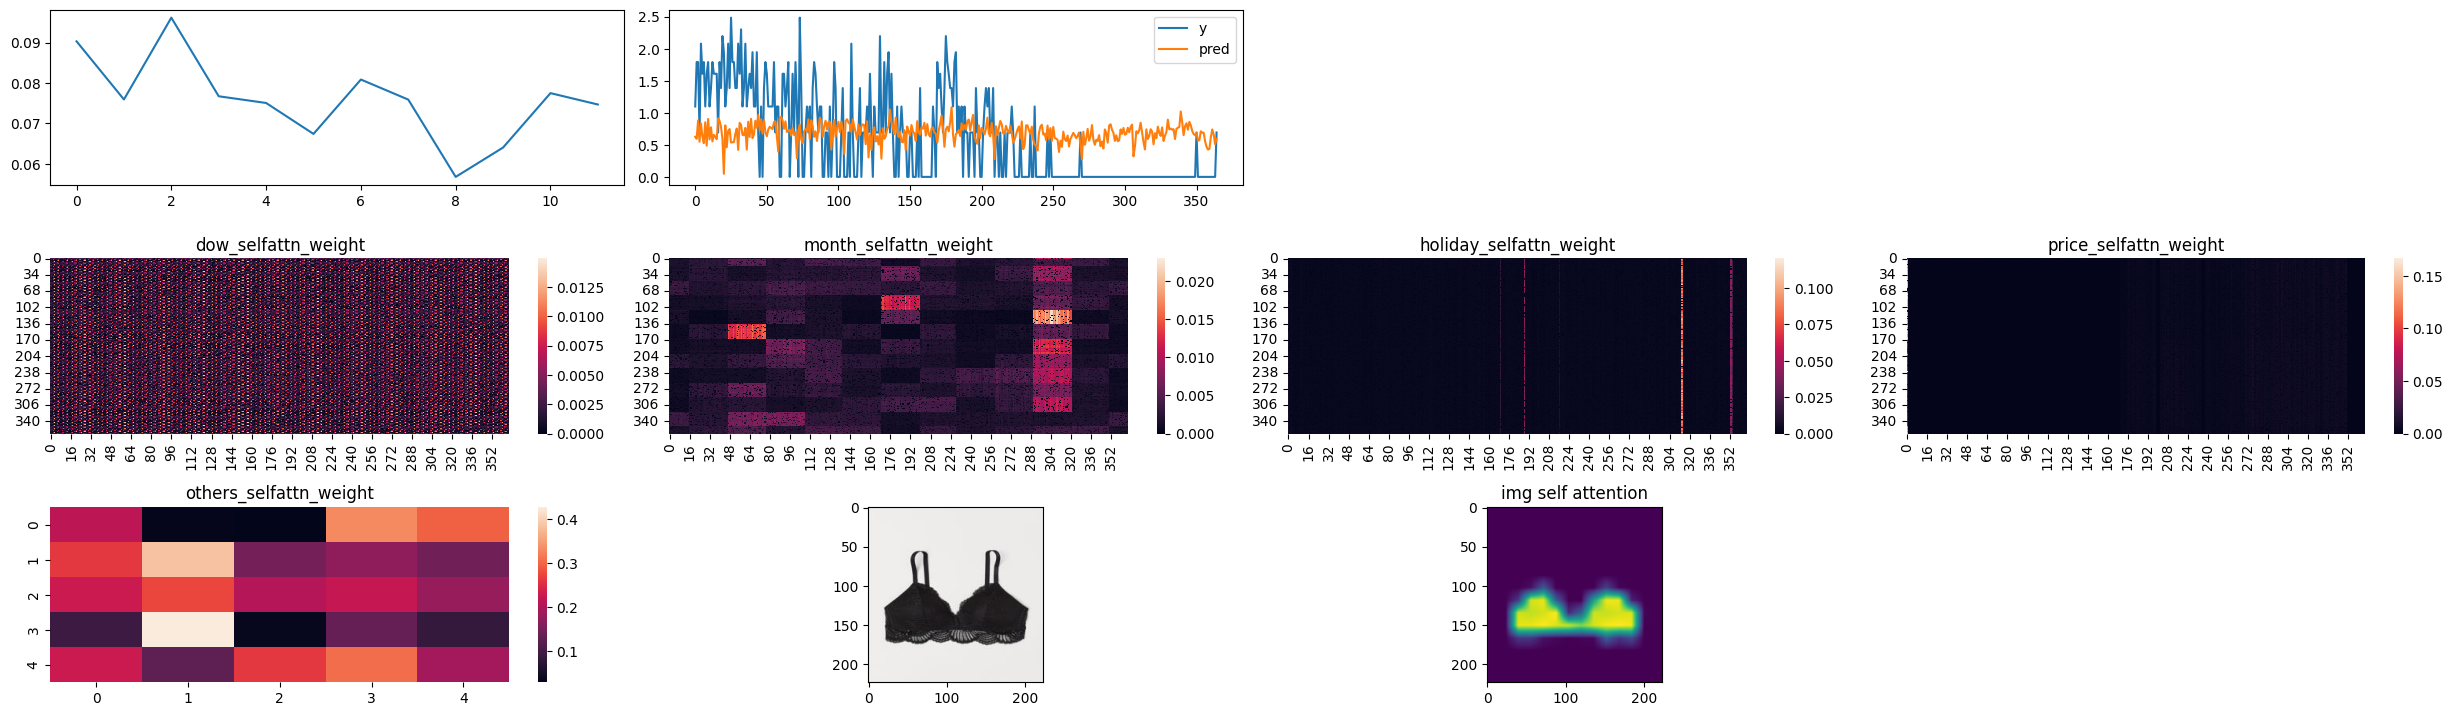

2 - loss: 0.07584224318464597, lr: 0.0009603999999999999:  75%|███████▌  | 127/169 [00:15<00:03, 11.96it/s]

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
mse_loss = torch.nn.MSELoss(reduction="none")
l1_loss = torch.nn.L1Loss(reduction="none")
scaler = torch.cuda.amp.GradScaler()

def loss_fn(pred, y, mask):
    mask = torch.where((mask==hide_mask_val), 1, 0)
    loss = mse_loss(pred, y)
    loss = mask * loss
    loss = loss.sum()/mask.sum()
    # loss = torch.sqrt(loss)
    return loss

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li = []
    window = 100
    grad_accm_step = 0

    for n, data in enumerate(pbar):
        with torch.cuda.amp.autocast():
            model.train()
            pred, dow_selfattn_weight, month_selfattn_weight, holiday_selfattn_weight, price_selfattn_weight, others_selfattn_weight, img_selfattn_weight = model(
                                    data["sales"].to(device),
                                    data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
                                    data["index_name"].to(device),  data["colour_group_name"].to(device),  data["graphical_appearance_name"].to(device),  data["product_type_name"].to(device),
                                    data["img_input"].to(device),
                                    data["mask"].to(device),
                                    )
            loss = loss_fn(pred[:, 1:], data["y"].to(device), data["mask"][:, 1:].to(device))
            loss = loss / grad_accm_step_max
        
        scaler.scale(loss).backward()
        grad_accm_step += 1

        if grad_accm_step == grad_accm_step_max:
            # optimizer.step()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            grad_accm_step = 0

            loss_li.append(loss.item())
            pbar.set_description(f"{e} - loss: {np.mean(loss_li[-window:])}, lr: {optimizer.param_groups[0]['lr']}")

        if n % 50 == 0:
            idx = 0
            plt.figure(figsize=(25,12))
            nrows, ncols = 5, 4
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, 1)
            plt.plot(loss_li[-window:])

            # Sample
            length = data["length"][idx]
            plt.subplot(nrows, ncols, 2)
            plt.plot(data["y"][idx][:length], label="y")
            plt.plot(pred[idx][:length].detach().cpu(), label="pred")
            plt.legend()

            # Attn
            plt.subplot(nrows, ncols, 5)
            sns.heatmap(dow_selfattn_weight[idx].mean(dim=0).detach().cpu())
            plt.title("dow_selfattn_weight")

            plt.subplot(nrows, ncols, 6)
            sns.heatmap(month_selfattn_weight[idx].mean(dim=0).detach().cpu())
            plt.title("month_selfattn_weight")

            plt.subplot(nrows, ncols, 7)
            sns.heatmap(holiday_selfattn_weight[idx].mean(dim=0).detach().cpu())
            plt.title("holiday_selfattn_weight")

            plt.subplot(nrows, ncols, 8)
            sns.heatmap(price_selfattn_weight[idx].mean(dim=0).detach().cpu())
            plt.title("price_selfattn_weight")

            plt.subplot(nrows, ncols, 9)
            sns.heatmap(others_selfattn_weight[idx].mean(dim=0).detach().cpu())
            plt.title("others_selfattn_weight")

            plt.subplot(nrows, ncols, 10)
            plt.imshow(data["img_raw"][idx])

            plt.subplot(nrows, ncols, 11)
            # patch_wh = (224//patch_size)
            patch_wh = 14
            img_selfattn_weight = img_selfattn_weight[-1].squeeze()[idx]
            mask = img_selfattn_weight.min(dim=0)[0][0][-(patch_wh**2):].reshape(patch_wh,patch_wh).cpu().detach().numpy() # 28,28 or 14,14
            mask = cv2.resize(mask / mask.max(), data["img_raw"][idx].size)[..., np.newaxis]
            plt.imshow(mask)
            plt.title("img self attention")

            plt.tight_layout()
            plt.show()

epoch = 5
for e in range(epoch):
    train(e)
    scheduler.step()

# Eval

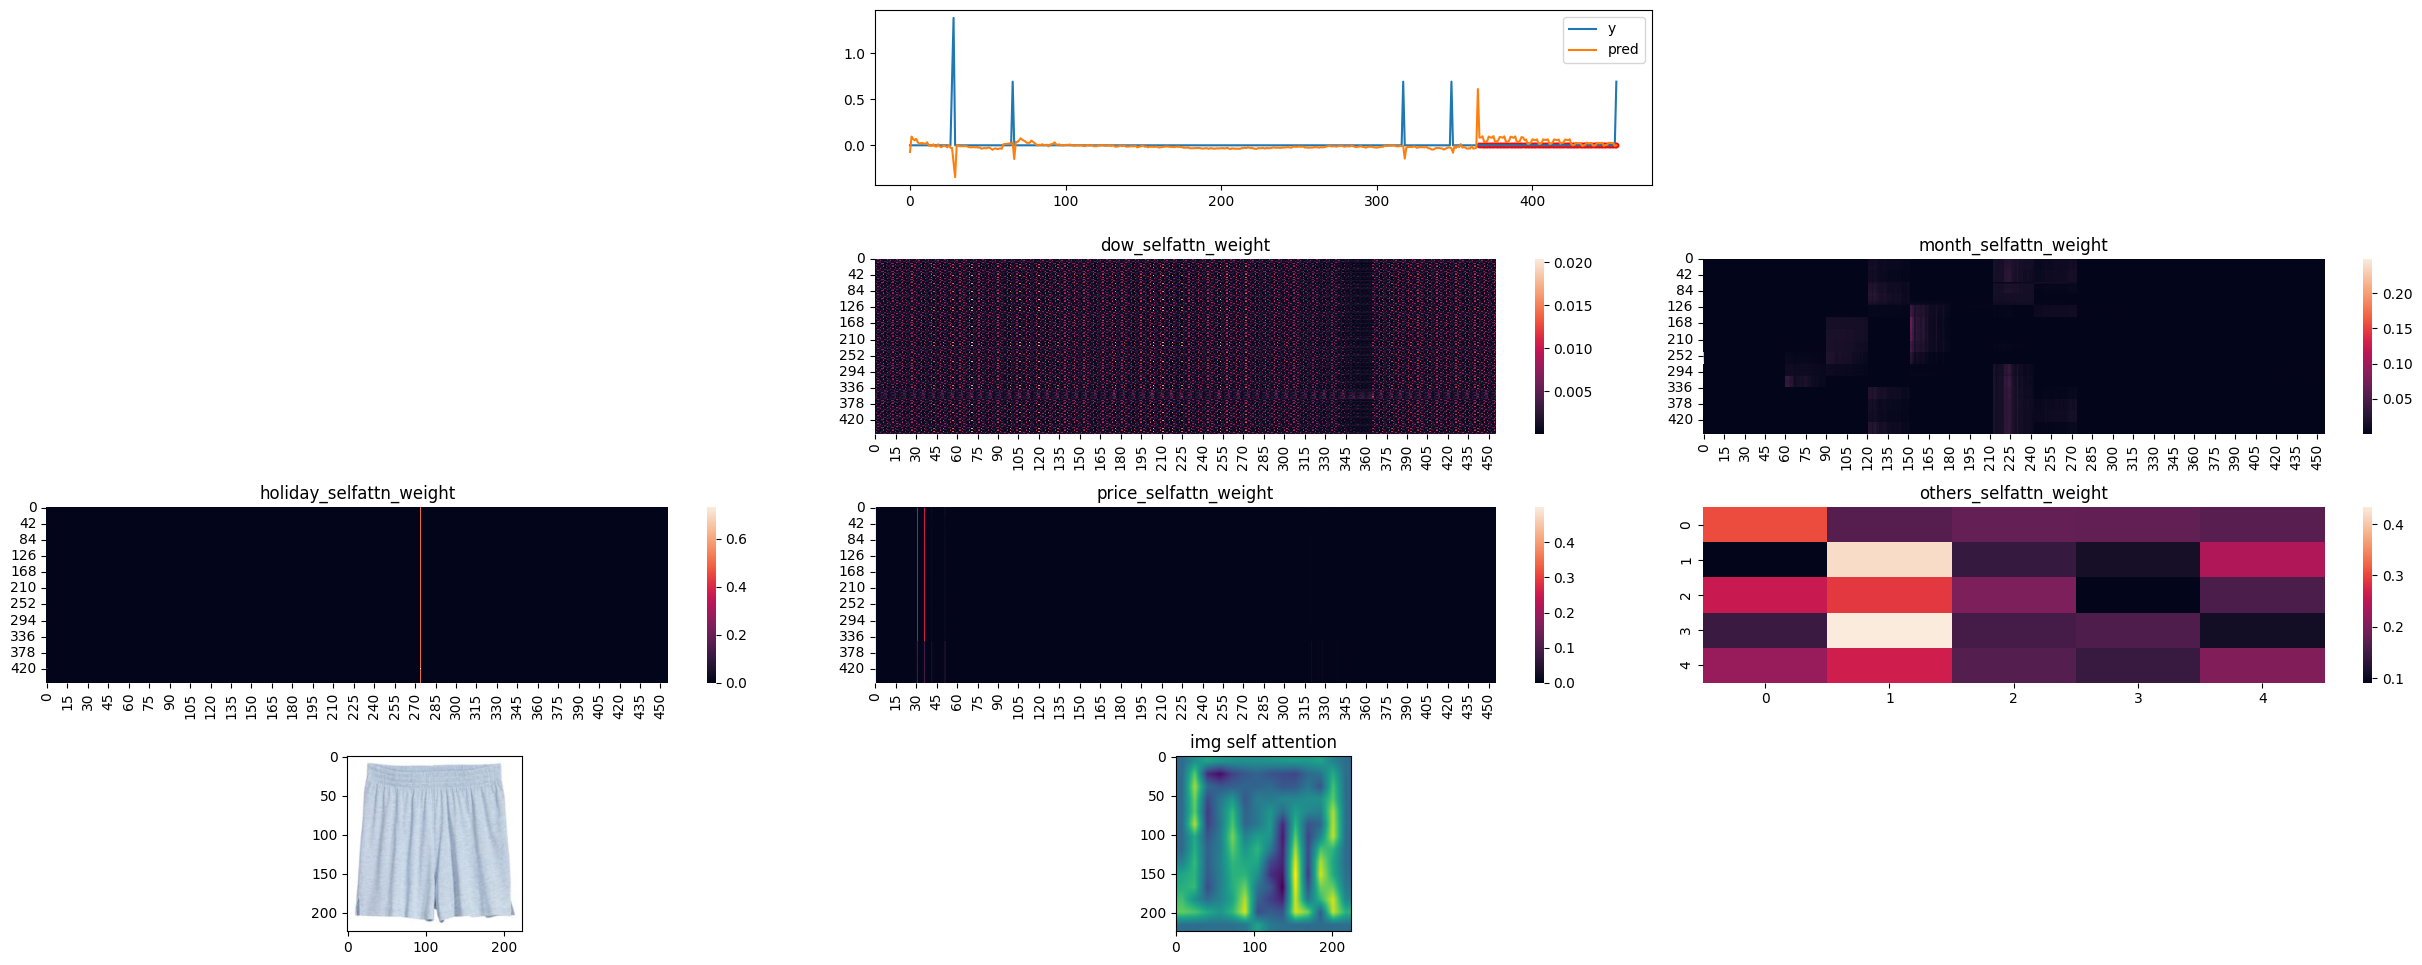

In [ ]:
model.eval()
pbar = tqdm(valid_dataloader)

for n, data in enumerate(pbar):
    with torch.no_grad():
        sales = data["sales"].to(device)
        mask = data["mask"].to(device)
        pred, dow_selfattn_weight, month_selfattn_weight, holiday_selfattn_weight, price_selfattn_weight, others_selfattn_weight, img_selfattn_weight = model(
                                data["sales"].to(device), 
                                data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
                                data["index_name"].to(device),  data["colour_group_name"].to(device),  data["graphical_appearance_name"].to(device),  data["product_type_name"].to(device),
                                data["img_input"].to(device),
                                data["mask"].to(device),
                                )

        # for i in range(30):
        #     pred, hist_hist_attnweight, hist_static_attnweight, hist_img_attnweight, img_self_attnweight = model(
        #                             sales, 
        #                             data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
        #                             data["index_name"].to(device),  data["colour_group_name"].to(device),  data["graphical_appearance_name"].to(device),  data["product_type_name"].to(device),
        #                             data["img_input"].to(device),
        #                             data["mask"].to(device),
        #                             )
        #     idx = torch.argmin(sales, -1)
        #     for n, i in enumerate(idx):
        #         sales[n, i] = pred[n, i]
        #         mask[n, i] = real_mask_val
        
        idx = 0
        # idx = data["y"][:, -1]
        # idx = torch.argmax(idx)
        plt.figure(figsize=(25,12))
        nrows, ncols = 5, 3
        clear_output(wait=True)

        # Sample
        length = data["length"][idx]
        plt.subplot(nrows, ncols, 2)
        plt.plot(data["y"][idx][:length], label="y")
        plt.plot(pred[idx][:length].detach().cpu(), label="pred")
        plt.scatter(np.arange(data["mask"][idx][:length].shape[0]), torch.where(data["mask"][idx]==1, 0, np.nan)[:length], color="red", s=10)
        plt.legend()

        # Attn
        plt.subplot(nrows, ncols, 5)
        sns.heatmap(dow_selfattn_weight[idx].mean(dim=0).detach().cpu())
        plt.title("dow_selfattn_weight")

        plt.subplot(nrows, ncols, 6)
        sns.heatmap(month_selfattn_weight[idx].mean(dim=0).detach().cpu())
        plt.title("month_selfattn_weight")

        plt.subplot(nrows, ncols, 7)
        sns.heatmap(holiday_selfattn_weight[idx].mean(dim=0).detach().cpu())
        plt.title("holiday_selfattn_weight")

        plt.subplot(nrows, ncols, 8)
        sns.heatmap(price_selfattn_weight[idx].mean(dim=0).detach().cpu())
        plt.title("price_selfattn_weight")

        plt.subplot(nrows, ncols, 9)
        sns.heatmap(others_selfattn_weight[idx].mean(dim=0).detach().cpu())
        plt.title("others_selfattn_weight")

        plt.subplot(nrows, ncols, 10)
        plt.imshow(data["img_raw"][idx])

        plt.subplot(nrows, ncols, 11)
        # patch_wh = (224//patch_size)
        patch_wh = 14
        img_selfattn_weight = img_selfattn_weight[-1].squeeze()[idx]
        mask = img_selfattn_weight.min(dim=0)[0][0][-(patch_wh**2):].reshape(patch_wh,patch_wh).cpu().detach().numpy() # 28,28 or 14,14
        mask = cv2.resize(mask / mask.max(), data["img_raw"][idx].size)[..., np.newaxis]
        plt.imshow(mask)
        plt.title("img self attention")

        plt.tight_layout()
        plt.show()
        input()